In [83]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

pd.options.display.max_rows = 30

two_months_ago = datetime.today() - timedelta(weeks=4)
two_months_foward = datetime.today() + timedelta(weeks=4)

## Produtos

In [84]:
# produtos
produtos = requests.get('http://127.0.0.1:5000/produtos').json()

## Pedido

In [85]:
# pedido
pedido = pd.read_json('pedido.json')
pedido['valorfinal'] = pd.to_numeric([x.split()[1] for x in pedido['valorfinal']])
pedido = pd.pivot_table(pedido, values=['valorfinal'], index='marca', aggfunc='sum').reset_index()
pedido.columns = ['marca', 'total']

In [86]:
# prazos
prazos = pd.read_csv('prazos.csv')
prazos.columns = ['marca',1,2,3]
prazos['n_parcelas'] = 3 - prazos.T.isna().sum()
prazos = prazos.merge(pedido)

In [87]:
# agenda
agenda = prazos.copy()
agenda
for parcela in [1,2,3]:
    agenda[parcela] = [datetime.today() + timedelta(days=x) if x > 0 else None for x in prazos[parcela]]
agenda['valor'] = agenda['total']/agenda['n_parcelas']
agenda = agenda.melt(id_vars=['marca', 'valor'], value_vars=[1,2,3], value_name='data', var_name='parcela').dropna()
agenda['semana'] = [x.isocalendar()[1] for x in agenda['data']]

In [88]:
# peso
peso = agenda.copy()
peso = pd.pivot_table(agenda, index=peso['data'], aggfunc='sum').reset_index()

## Situação

In [89]:
# contas
vendas = list()
data = {
    'formato': 'json',
    'token': '2b6fc7102240cedcc9166c43921ea73eea82b876',
    'dataInicial': two_months_ago.strftime('%d/%m/%Y'),
    'dataFinal': datetime.today().strftime('%d/%m/%Y'),
    'pagina': 1
}
while True:
    try:

        url = 'https://api.tiny.com.br/api2/pedidos.pesquisa.php'
        vendas += [x['pedido'] for x in requests.post(url, data).json()['retorno']['pedidos']]
        data['pagina'] += 1
    except:
        break
vendas = pd.DataFrame(vendas)


In [90]:
# faturamento diário
faturamento_estimado = vendas['valor'].sum()/30

In [91]:
# contas
contas = list()
data = {
    'formato': 'json',
    'token': '2b6fc7102240cedcc9166c43921ea73eea82b876',
    'data_ini_vencimento': datetime.today().strftime('%d/%m/%Y'),
    'data_fim_vencimento': agenda['data'].max().strftime('%d/%m/%Y'),
    'pagina': 1
}
while True:
    try:
        url = 'https://api.tiny.com.br/api2/contas.pagar.pesquisa.php'
        contas += [x['conta'] for x in requests.post(url, data).json()['retorno']['contas']]
        data['pagina'] += 1
    except:
        break
contas = pd.DataFrame(contas)
contas = contas.T.reindex(['data_vencimento', 'valor']).T
contas.columns = ['data', 'valor']
contas['data'] = [datetime.strptime(x, '%d/%m/%Y') for x in contas['data']]

In [92]:
# saldo
saldo = pd.DataFrame(contas['data'])
saldo['valor'] = np.repeat(faturamento_estimado, len(contas)) - pd.to_numeric(contas['valor'])

## Divisão por semanas

In [93]:
# saldo
saldo_semanal = saldo.copy()
saldo_semanal['semana'] = [x.isocalendar()[1] for x in saldo['data']]
saldo_semanal = pd.pivot_table(saldo_semanal, index='semana', values='valor', aggfunc='sum')

In [94]:
# compras
peso_semanal = peso.copy()
peso_semanal['semana'] = [x.isocalendar()[1] for x in peso['data']]
peso_semanal = pd.pivot_table(peso_semanal, index='semana', values='valor', aggfunc='sum')

## analise

In [139]:
# analise
def rweek(semana):
    return datetime.fromisocalendar(datetime.today().year, semana, 1), datetime.fromisocalendar(datetime.today().year, semana, 7)

analise = peso_semanal.join(saldo_semanal, lsuffix='_compras',rsuffix='_saldo').fillna(faturamento_estimado*7)
analise['subtracao'] = analise['valor_saldo'] - analise['valor_compras']
analise['intervalo'] = [rweek(x) for x in analise.index]
analise['aprovado'] = [x > 0 for x in analise['subtracao']]
analise.reset_index(inplace=True)
analise = analise.T.reindex(['aprovado', 'intervalo', 'subtracao', 'valor_compras', 'valor_saldo', 'semana']).T

In [112]:
# negadas
negadas = analise[analise['aprovado'] == False]
negadas = negadas.merge(agenda)
negadas = negadas.T.reindex(['marca', 'data', 'valor']).T

## Formatacao

Text(0.5, 1.0, 'Compras')

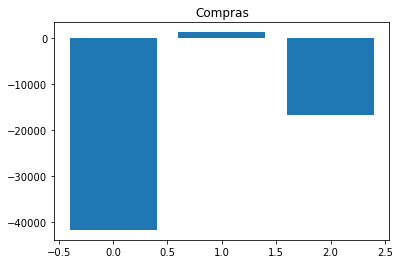

In [97]:
x, y = analise.index, analise['subtracao']

plt.bar(x, y)
plt.title('Compras')

## Plotagem

In [148]:
negadas

,marca,data,valor
0,Alimentar,2022-06-12 21:14:25.264021,21709.0
1,Di Prima,2022-06-12 21:14:25.264021,199.5
2,Minerva,2022-06-12 21:14:25.264021,26689.333333
3,Minerva,2022-06-26 21:14:25.265049,26689.333333


In [161]:
negadas_f = negadas.copy()
negadas_f['data'] = [x.strftime('%d/%m/%Y') for x in negadas['data']]
negadas_f.to_dict(orient='records')

analise_f = analise.copy()
analise_f['intervalo'] = [[x[0].strftime('%d/%m/%Y'), x[1].strftime('%d/%m/%Y')] for x in analise_f['intervalo']]

resultado = {'analise': analise_f.to_dict(orient='records'), 'negadas': negadas_f.to_dict(orient='records'), 'valor': negadas['valor'].sum()}

import json

json.dumps(resultado)

'{"analise": [{"aprovado": false, "intervalo": ["06/06/2022", "12/06/2022"], "subtracao": -41785.05933333333, "valor_compras": 48597.83333333333, "valor_saldo": 6812.774, "semana": 23}, {"aprovado": true, "intervalo": ["13/06/2022", "19/06/2022"], "subtracao": 1292.172666666669, "valor_compras": 26689.333333333332, "valor_saldo": 27981.506, "semana": 24}, {"aprovado": false, "intervalo": ["20/06/2022", "26/06/2022"], "subtracao": -16790.58933333333, "valor_compras": 26689.333333333332, "valor_saldo": 9898.744, "semana": 25}], "negadas": [{"marca": "Alimentar", "data": "12/06/2022", "valor": 21709.0}, {"marca": "Di Prima", "data": "12/06/2022", "valor": 199.5}, {"marca": "Minerva", "data": "12/06/2022", "valor": 26689.333333333332}, {"marca": "Minerva", "data": "26/06/2022", "valor": 26689.333333333332}], "valor": 75287.16666666666}'